# Libraries

In [1]:
import pandas as pd
import numpy as np

## Set up graphics environment

In [2]:
import seaborn as sns; sns.set()
%matplotlib inline

# Configs

## Regular expressions for OHCO 

In [3]:
BODY_START = 341
BODY_END = 21964
CHAP_PAT = r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$'
PARA_PAT = r'\n\n+'
SENT_PAT = r'([.;?!"“”]+)'
TOKEN_PAT = r'(\W+)'

## The file

In [4]:
src_file = '2701-0.txt'

# Get the text as a list of lines

In [5]:
lines = open(src_file, 'r', encoding='utf-8').readlines()

In [6]:
lines[:5]

['\ufeff\n',
 'The Project Gutenberg EBook of Moby Dick; or The Whale, by Herman\n',
 'Melville\n',
 '\n',
 'This eBook is for the use of anyone anywhere at no cost and with almost\n']

# OHCO 1: Get Body 

Remove front and backmatter

## Clip at points discovered by visual inspection

In [7]:
lines = lines[BODY_START - 1 : BODY_END + 1]

In [8]:
lines[:5]

['  ETYMOLOGY.\n',
 '\n',
 '\n',
 '  (Supplied by a Late Consumptive Usher to a Grammar School.)\n',
 '\n']

In [9]:
lines[-6:-1]

['unharming sharks, they glided by as if with padlocks on their mouths;\n',
 'the savage sea-hawks sailed with sheathed beaks. On the second day, a\n',
 'sail drew near, nearer, and picked me up at last. It was the\n',
 'devious-cruising Rachel, that in her retracing search after her missing\n',
 'children, only found another orphan.\n']

## Convert list to data frame

In [10]:
df = pd.DataFrame({'line_str':lines})
df.index.name = 'line_id'

In [11]:
df.head()

,line_str
line_id,
0,ETYMOLOGY.\n
1,\n
2,\n
3,(Supplied by a Late Consumptive Usher to a G...
4,\n


## View raw lines

In [12]:
df.line_str.values.tolist()[:30]

['  ETYMOLOGY.\n',
 '\n',
 '\n',
 '  (Supplied by a Late Consumptive Usher to a Grammar School.)\n',
 '\n',
 '  The pale Usher—threadbare in coat, heart, body, and brain; I see him\n',
 '  now. He was ever dusting his old lexicons and grammars, with a queer\n',
 '  handkerchief, mockingly embellished with all the gay flags of all the\n',
 '  known nations of the world. He loved to dust his old grammars; it\n',
 '  somehow mildly reminded him of his mortality.\n',
 '\n',
 '  “While you take in hand to school others, and to teach them by what\n',
 '  name a whale-fish is to be called in our tongue, leaving out, through\n',
 '  ignorance, the letter H, which almost alone maketh up the\n',
 '  signification of the word, you deliver that which is not true.”\n',
 '  —_Hackluyt._\n',
 '\n',
 '  “WHALE. * * * Sw. and Dan. _hval_. This animal is named from\n',
 '  roundness or rolling; for in Dan. _hvalt_ is arched or vaulted.”\n',
 '  —_Webster’s Dictionary._\n',
 '\n',
 '  “WHALE. * * * It is

# OCHO 2: Chunk by Chapter

We follow the **LABEL-GROUP-JOIN** pattern

## Identify and label chapter titles by regexes

We use the row index as the ID of the chapter for the time being. We do not use the chapter title itself because we want a numeric value to be our index.

In [13]:
# df.loc[df.line_str.str.match(CHAP_PAT), 'chap_id'] = df.line_str 
# df.chap_id = df.chap_id.ffill()

In [14]:
df.loc[df.line_str.str.match(CHAP_PAT), 'chap_id'] = df.apply(lambda x: x.name, 1)
df.chap_id = df.chap_id.ffill().astype('int')

In [15]:
df.head()

,line_str,chap_id
line_id,,
0,ETYMOLOGY.\n,0
1,\n,0
2,\n,0
3,(Supplied by a Late Consumptive Usher to a G...,0
4,\n,0


## Convert temporary IDs to sequential numbers

We get the unique chapter names and convert them to a list

In [16]:
chap_ids = df.chap_id.unique().tolist()

In [17]:
chap_ids[:5]

[0, 508, 709, 843, 1413]

In [18]:
chap_ids.index(709)

2

In [19]:
df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))

In [20]:
df.tail()

,line_str,chap_id,chap_num
line_id,,,
21620,the savage sea-hawks sailed with sheathed beak...,21597,136
21621,"sail drew near, nearer, and picked me up at la...",21597,136
21622,"devious-cruising Rachel, that in her retracing...",21597,136
21623,"children, only found another orphan.\n",21597,136
21624,\n,21597,136


## Look at list of chapter numbers

In [21]:
df.chap_num.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136])

## Group and gather lines into chapter chunks

Group By is a powerful data frame method!

In [22]:
# %%timeit
# chaps = df.groupby('chap_num')\
#     .apply(lambda x: x.line_str.str.cat(sep=''))\
#     .to_frame()\
#     .rename(columns={0:'chap_str'})

In [23]:
# %%timeit
chaps = df.groupby('chap_num')\
    .apply(lambda x: ''.join(x.line_str))\
    .to_frame()\
    .rename(columns={0:'chap_str'})

In [24]:
chaps.head()

,chap_str
chap_num,
0,ETYMOLOGY.\n\n\n (Supplied by a Late Consum...
1,CHAPTER 1. Loomings.\n\nCall me Ishmael. Some ...
2,CHAPTER 2. The Carpet-Bag.\n\nI stuffed a shir...
3,CHAPTER 3. The Spouter-Inn.\n\nEntering that g...
4,CHAPTER 4. The Counterpane.\n\nUpon waking nex...


## Observe the structure of the data frame

The data frame has an index column for the chapter number.

To grab a row by chapter number, do this:

In [25]:
chaps.loc[5]

chap_str    CHAPTER 5. Breakfast.\n\nI quickly followed su...
Name: 5, dtype: object

In [26]:
chaps.loc[5].to_frame().T

,chap_str
5,CHAPTER 5. Breakfast.\n\nI quickly followed su...


In [27]:
chaps.loc[:5]

,chap_str
chap_num,
0,ETYMOLOGY.\n\n\n (Supplied by a Late Consum...
1,CHAPTER 1. Loomings.\n\nCall me Ishmael. Some ...
2,CHAPTER 2. The Carpet-Bag.\n\nI stuffed a shir...
3,CHAPTER 3. The Spouter-Inn.\n\nEntering that g...
4,CHAPTER 4. The Counterpane.\n\nUpon waking nex...
5,CHAPTER 5. Breakfast.\n\nI quickly followed su...


In [28]:
chaps.loc[[1,5]]

,chap_str
chap_num,
1,CHAPTER 1. Loomings.\n\nCall me Ishmael. Some ...
5,CHAPTER 5. Breakfast.\n\nI quickly followed su...


## Check results by looking at last chapter

In [29]:
chaps.values.tolist()[136]

['Epilogue\n\n“AND I ONLY AM ESCAPED ALONE TO TELL THEE” Job.\n\nThe drama’s done. Why then here does any one step forth?—Because one\ndid survive the wreck.\n\nIt so chanced, that after the Parsee’s disappearance, I was he whom the\nFates ordained to take the place of Ahab’s bowsman, when that bowsman\nassumed the vacant post; the same, who, when on the last day the three\nmen were tossed from out of the rocking boat, was dropped astern. So,\nfloating on the margin of the ensuing scene, and in full sight of it,\nwhen the halfspent suction of the sunk ship reached me, I was then, but\nslowly, drawn towards the closing vortex. When I reached it, it had\nsubsided to a creamy pool. Round and round, then, and ever contracting\ntowards the button-like black bubble at the axis of that slowly\nwheeling circle, like another Ixion I did revolve. Till, gaining that\nvital centre, the black bubble upward burst; and now, liberated by\nreason of its cunning spring, and, owing to its great buoyancy,

In [30]:
chaps.loc[136].values.tolist()[0]

'Epilogue\n\n“AND I ONLY AM ESCAPED ALONE TO TELL THEE” Job.\n\nThe drama’s done. Why then here does any one step forth?—Because one\ndid survive the wreck.\n\nIt so chanced, that after the Parsee’s disappearance, I was he whom the\nFates ordained to take the place of Ahab’s bowsman, when that bowsman\nassumed the vacant post; the same, who, when on the last day the three\nmen were tossed from out of the rocking boat, was dropped astern. So,\nfloating on the margin of the ensuing scene, and in full sight of it,\nwhen the halfspent suction of the sunk ship reached me, I was then, but\nslowly, drawn towards the closing vortex. When I reached it, it had\nsubsided to a creamy pool. Round and round, then, and ever contracting\ntowards the button-like black bubble at the axis of that slowly\nwheeling circle, like another Ixion I did revolve. Till, gaining that\nvital centre, the black bubble upward burst; and now, liberated by\nreason of its cunning spring, and, owing to its great buoyancy, 

# OHCO 3: Chunk by Paragraph

We follow the **SPLIT-EXPAND-STACK** pattern.

## Split by regex and stack 

In [31]:
paras = chaps.chap_str.str.split(PARA_PAT, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'para_str'})
paras.index.names = ['chap_num', 'para_num']

Check results. Look at the index now.

In [32]:
paras.head(100)

para_str
chap_num para_num                                                   
0        0                                                ETYMOLOGY.
         1           (Supplied by a Late Consumptive Usher to a G...
         2           The pale Usher—threadbare in coat, heart, bo...
         3           “While you take in hand to school others, an...
         4           “WHALE. * * * Sw. and Dan. _hval_. This anim...
         5           “WHALE. * * * It is more immediately from th...
         6           חו,                 _Hebrew_.\n  ϰητος,     ...
         7              EXTRACTS. (Supplied by a Sub-Sub-Librarian).
         8           It will be seen that this mere painstaking b...
         9           So fare thee well, poor devil of a Sub-Sub, ...
         10                                                EXTRACTS.
         11              “And God created great whales.” —_Genesis_.
         12          “Leviathan maketh a path to shine after him;...
         13          “Now the Lord had prepared a great fish to s...
         14          “There go the ships; there is that Leviathan...
         15          “In that day, the Lord with his sore, and gr...
         16          “And what thing soever besides cometh within...
         17          “The Indian Sea breedeth the most and the bi...
         18          “Scarcely had we proceeded two days on the s...
         19          “He visited this country also with a view of...
         20          “And whereas all the other things, whether b...
         21          “Let us fly, let us fly! Old Nick take me if...
         22          “This whale’s liver was two cartloads.” —_St...
         23          “The great Leviathan that maketh the seas to...
         24          “Touching that monstrous bulk of the whale o...
         25          “The sovereignest thing on earth is parmacet...
         26                          “Very like a whale.” —_Hamlet_.
         27          “Which to secure, no skill of leach’s art Mo...
         28          “Immense as whales, the motion of whose vast...
         29          “What spermacetti is, men might justly doubt...
...                                                              ...
         70          “A mariner sat in the shrouds one night, The...
         71          “The quantity of line withdrawn from the boa...
         72          “Sometimes the whale shakes its tremendous t...
         73          “Mad with the agonies he endures from these ...
         74          “The Cachalot” (Sperm Whale) “is not only be...
         75          October 13.  “There she blows,” was sung out...
         76          “The Whale-ship Globe, on board of which ves...
         77          Being once pursued by a whale which he had w...
         78          “Nantucket itself,” said Mr. Webster, “is a ...
         79          “The whale fell directly over him, and proba...
         80          “If you make the least damn bit of noise,” r...
         81          “The voyages of the Dutch and English to the...
         82          “These things are reciprocal; the ball rebou...
         83          “It is impossible to meet a whale-ship on th...
         84          “Pedestrians in the vicinity of London and e...
         85          “It was not till the boats returned from the...
         86          “It is generally well known that out of the ...
         87          “Suddenly a mighty mass emerged from the wat...
         88          “The Whale is harpooned to be sure; but beth...
         89          “On one occasion I saw two of these monsters...
         90          “‘Stern all!’ exclaimed the mate, as upon tu...
         91          “So be cheery, my lads, let your hearts neve...
         92          “Oh, the rare old Whale, mid storm and gale ...
         93                                                         
1        0                                      CHAPTER 1. Loomings.
         1         Call me Ishmael. Some years ago—never m

In [33]:
paras.iloc[:5,0]

chap_num  para_num
0         0                                                  ETYMOLOGY.
          1             (Supplied by a Late Consumptive Usher to a G...
          2             The pale Usher—threadbare in coat, heart, bo...
          3             “While you take in hand to school others, an...
          4             “WHALE. * * * Sw. and Dan. _hval_. This anim...
Name: para_str, dtype: object

In [34]:
paras.iloc[:5,0].values.tolist()

['  ETYMOLOGY.',
 '  (Supplied by a Late Consumptive Usher to a Grammar School.)',
 '  The pale Usher—threadbare in coat, heart, body, and brain; I see him\n  now. He was ever dusting his old lexicons and grammars, with a queer\n  handkerchief, mockingly embellished with all the gay flags of all the\n  known nations of the world. He loved to dust his old grammars; it\n  somehow mildly reminded him of his mortality.',
 '  “While you take in hand to school others, and to teach them by what\n  name a whale-fish is to be called in our tongue, leaving out, through\n  ignorance, the letter H, which almost alone maketh up the\n  signification of the word, you deliver that which is not true.”\n  —_Hackluyt._',
 '  “WHALE. * * * Sw. and Dan. _hval_. This animal is named from\n  roundness or rolling; for in Dan. _hvalt_ is arched or vaulted.”\n  —_Webster’s Dictionary._']

In [35]:
paras.loc[10]

,para_str
para_num,
0,CHAPTER 10. A Bosom Friend.
1,"Returning to the Spouter-Inn from the Chapel, ..."
2,"But being now interrupted, he put up the image..."
3,With much interest I sat watching him. Savage ...
4,"Whilst I was thus closely scanning him, half-p..."
5,As I sat there in that now lonely room; the fi...
6,"We then turned over the book together, and I e..."
7,If there yet lurked any ice of indifference to...
8,"After supper, and another social chat and smok..."


In [36]:
paras.loc[(1,1)]

para_str    Call me Ishmael. Some years ago—never mind how...
Name: (1, 1), dtype: object

## Clean up 

In [37]:
paras.para_str = paras.para_str.str.strip()
paras.para_str = paras.para_str.str.replace(r'\n', ' ')
paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
paras = paras[~paras.para_str.str.match(r'^\s*$')]

In [38]:
paras

para_str
chap_num para_num                                                   
0        0                                                ETYMOLOGY.
         1         (Supplied by a Late Consumptive Usher to a Gra...
         2         The pale Usher—threadbare in coat, heart, body...
         3         “While you take in hand to school others, and ...
         4         “WHALE. * * * Sw. and Dan. _hval_. This animal...
         5         “WHALE. * * * It is more immediately from the ...
         6         חו, _Hebrew_. ϰητος, _Greek_. CETUS, _Latin_. ...
         7              EXTRACTS. (Supplied by a Sub-Sub-Librarian).
         8         It will be seen that this mere painstaking bur...
         9         So fare thee well, poor devil of a Sub-Sub, wh...
         10                                                EXTRACTS.
         11              “And God created great whales.” —_Genesis_.
         12        “Leviathan maketh a path to shine after him; O...
         13        “Now the Lord had prepared a great fish to swa...
         14        “There go the ships; there is that Leviathan w...
         15        “In that day, the Lord with his sore, and grea...
         16        “And what thing soever besides cometh within t...
         17        “The Indian Sea breedeth the most and the bigg...
         18        “Scarcely had we proceeded two days on the sea...
         19        “He visited this country also with a view of c...
         20        “And whereas all the other things, whether bea...
         21        “Let us fly, let us fly! Old Nick take me if i...
         22        “This whale’s liver was two cartloads.” —_Stow...
         23        “The great Leviathan that maketh the seas to s...
         24        “Touching that monstrous bulk of the whale or ...
         25        “The sovereignest thing on earth is parmacetti...
         26                          “Very like a whale.” —_Hamlet_.
         27        “Which to secure, no skill of leach’s art Mote...
         28        “Immense as whales, the motion of whose vast b...
         29        “What spermacetti is, men might justly doubt, ...
...                                                              ...
135      37        “Oh! Ahab,” cried Starbuck, “not too late is i...
         38        Setting sail to the rising wind, the lonely bo...
         39        Whether fagged by the three days’ running chas...
         40        “Heed them not! those teeth but give new rowlo...
         41        “But at every bite, sir, the thin blades grow ...
         42        “They will last long enough! pull on!—But who ...
         43        At length as the craft was cast to one side, a...
         44        Almost simultaneously, with a mighty volition ...
         45        “What breaks in me? Some sinew cracks!—’tis wh...
         46        Hearing the tremendous rush of the sea-crashin...
         47        Ahab staggered; his hand smote his forehead. “...
         48        “The whale! The ship!” cried the cringing oars...
         49        “Oars! oars! Slope downwards to thy depths, O ...
         50        But as the oarsmen violently forced their boat...
         51        Meantime, for that one beholding instant, Tash...
         52        “The whale, the whale! Up helm, up helm! Oh, a...
         53        “Stand not by me, but stand under me, whoever ...
         54        “Cherries? I only wish that we were where they...
         55        From the ship’s bows, nearly all the seamen no...
         56        “The ship! The hearse!—the second hearse!” cri...
         57        Diving beneath the settling ship, the whale ra...
         58        “I turn my body from the sun. What ho, Tashteg...
         59        The harpoon was darted; the stricken whale fle...
         60        For an instant, the tranced boat’s crew stood ...
         61        But as the last whelmings intermixingly poured...
         62        Now small fowls flew screaming over the

# OHCO 4: Chunk by Sentence

We follow the **SPLIT-GROUP-JOIN** pattern again.

In [39]:
sents = paras.para_str.str.split(SENT_PAT, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'sent_str'})
sents.index.names = ['chap_num', 'para_num', 'sent_num']

In [40]:
sents.sample(10)

,,,sent_str
chap_num,para_num,sent_num,
135,28,35,;
128,4,4,Have ye seen a whale-boat adrift
100,38,6,"What is best let alone, that accursed thing i..."
107,5,54,"So, if his superiors wanted to use the carpen..."
64,42,5,;
32,37,2,"(_Octavo_), CHAPTER IV"
59,3,15,!
19,4,1,“
87,8,2,Unlike the straight perpendicular twin-jets o...


In [41]:
sents[sents.sent_str.str.match(r'\w+')].sample(10).values.tolist()

[['They will last long enough'],
 ['Stubb was struck by a shower of outcries and anathemas proceeding from the Captain’s round-house abaft'],
 ['At the period of our arrival at the Island, the heaviest storage of the Pequod had been almost completed'],
 ['All honor to the Enderbies, therefore, whose house, I think, exists to the present day'],
 ['From his mighty bulk the whale affords a most congenial theme whereon to enlarge, amplify, and generally expatiate'],
 ['Oh, thou dark Hindoo half of nature, who of drowned bones hast builded thy separate throne somewhere in the heart of these unverdured seas'],
 ['Here are his reflections some time after quitting the ship, during a black night in an open boat, when almost despairing of reaching any hospitable shore'],
 ['Excellent'],
 ['Some two years prior to my first learning the events which I am about rehearsing to you, gentlemen, the Town-Ho, Sperm Whaler of Nantucket, was cruising in your Pacific here, not very many days’ sail eastward 

# Tokenize

Again, use the **SPLIT-GROUP-JOIN** pattern.

In [42]:
tokens = sents.sent_str.str.split(TOKEN_PAT, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'token_str'})
tokens.index.names = ['chap_num', 'para_num', 'sent_num', 'token_num']

In [43]:
tokens

token_str
chap_num para_num sent_num token_num             
0        0        0        0            ETYMOLOGY
                  1        0                     
                           1                    .
                           2                     
                  2        0                     
         1        0        0                     
                           1                    (
                           2             Supplied
                           3                     
                           4                   by
                           5                     
                           6                    a
                           7                     
                           8                 Late
                           9                     
                           10         Consumptive
                           11                    
                           12               Usher
                           13                    
                           14                  to
                           15                    
                           16                   a
                           17                    
                           18             Grammar
                           19                    
                           20              School
                  1        0                     
                           1                    .
                           2                     
                  2        0                     
...                                           ...
136      3        22       13                  , 
                           14                that
                           15                    
                           16                  in
                           17                    
                           18                 her
                           19                    
                           20           retracing
                           21                    
                           22              search
                           23                    
                           24               after
                           25                    
                           26                 her
                           27                    
                           28             missing
                           29                    
                           30            children
                           31                  , 
                           32                only
                           33                    
                           34               found
                           35                    
                           36             another
                           37                    
                           38              orphan
                  23       0                     
                           1                    .
                           2                     
                  24       0                     

[502166 rows x 1 columns]

## Now get paragraphs and chapters back

In [44]:
paras2 = tokens.groupby(['chap_num','para_num']).token_str.apply(lambda x: ''.join(x))\
    .to_frame()\
    .rename(columns={'token_str':'para_str'})

In [45]:
paras2.head()

para_str
chap_num para_num                                                   
0        0                                                ETYMOLOGY.
         1         (Supplied by a Late Consumptive Usher to a Gra...
         2         The pale Usher—threadbare in coat, heart, body...
         3         “While you take in hand to school others, and ...
         4         “WHALE. * * * Sw. and Dan. _hval_. This animal...

In [46]:
chaps2 = paras2.groupby(['chap_num']).para_str.apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'para_str':'chap_str'})

In [47]:
chaps2.head()

,chap_str
chap_num,
0,ETYMOLOGY. (Supplied by a Late Consumptive Ush...
1,CHAPTER 1. Loomings. Call me Ishmael. Some yea...
2,CHAPTER 2. The Carpet-Bag. I stuffed a shirt o...
3,CHAPTER 3. The Spouter-Inn. Entering that gabl...
4,CHAPTER 4. The Counterpane. Upon waking next m...


In [48]:
chaps2

,chap_str
chap_num,
0,ETYMOLOGY. (Supplied by a Late Consumptive Ush...
1,CHAPTER 1. Loomings. Call me Ishmael. Some yea...
2,CHAPTER 2. The Carpet-Bag. I stuffed a shirt o...
3,CHAPTER 3. The Spouter-Inn. Entering that gabl...
4,CHAPTER 4. The Counterpane. Upon waking next m...
5,"CHAPTER 5. Breakfast. I quickly followed suit,..."
6,CHAPTER 6. The Street. If I had been astonishe...
7,CHAPTER 7. The Chapel. In this same New Bedfor...
8,CHAPTER 8. The Pulpit. I had not been seated v...


## General Function

In [49]:
def gather_chunks(df, div_names, doc_str = 'token_str', sep=''):
    chunks = df.groupby(div_names)[doc_str].apply(lambda x: x.str.cat(sep=sep))
    chunks.columns = ['doc_content']
    return chunks

## Test on sentences

In [50]:
sents2 = gather_chunks(tokens, ['chap_num', 'para_num', 'sent_num'])

In [51]:
sents2.to_frame()

token_str
chap_num para_num sent_num                                                   
0        0        0                                                 ETYMOLOGY
                  1                                                         .
                  2                                                          
         1        0         (Supplied by a Late Consumptive Usher to a Gra...
                  1                                                         .
                  2                                                         )
         2        0         The pale Usher—threadbare in coat, heart, body...
                  1                                                         ;
                  2                                             I see him now
                  3                                                         .
                  4          He was ever dusting his old lexicons and gram...
                  5                                                         .
                  6                         He loved to dust his old grammars
                  7                                                         ;
                  8           it somehow mildly reminded him of his mortality
                  9                                                         .
                  10                                                         
         3        0                                                          
                  1                                                         “
                  2         While you take in hand to school others, and t...
                  3                                                        .”
                  4                                                —_Hackluyt
                  5                                                         .
                  6                                                         _
         4        0                                                          
                  1                                                         “
                  2                                                     WHALE
                  3                                                         .
                  4                                                  * * * Sw
                  5                                                         .
...                                                                       ...
136      2        2                     Why then here does any one step forth
                  3                                                         ?
                  4                        —Because one did survive the wreck
                  5                                                         .
                  6                                                          
         3        0         It so chanced, that after the Parsee’s disappe...
                  1                                                         ;
                  2          the same, who, when on the last day the three...
                  3                                                         .
                  4          So, floating on the margin of the ensuing sce...
                  5                                                         .
                  6          When I reached it, it had subsided to a cream...
                  7                                                         .
                  8          Round and round, then, and ever contracting t...
                  9                                                         .
                  10         Till, gaining that vital centre, the black bu...
                  11                                                        ;
                  12         and now, liberated by reason of its cunning s...
                  13                                                        .
            

# Tag puncuation

In [52]:
tokens['punc'] = tokens.token_str.str.match(r'^\W*$').astype('int')

## View non-puncuation token counts

In [53]:
token_counts = tokens[tokens.punc == 0].token_str.str.lower().value_counts()

In [54]:
token_counts.head(25)

the      14418
of        6609
and       6430
a         4731
to        4625
in        4170
that      3066
his       2528
it        2519
i         2120
he        1892
but       1818
s         1796
as        1740
is        1724
with      1721
was       1644
for       1617
all       1525
this      1390
at        1319
whale     1213
by        1198
not       1152
from      1087
Name: token_str, dtype: int64

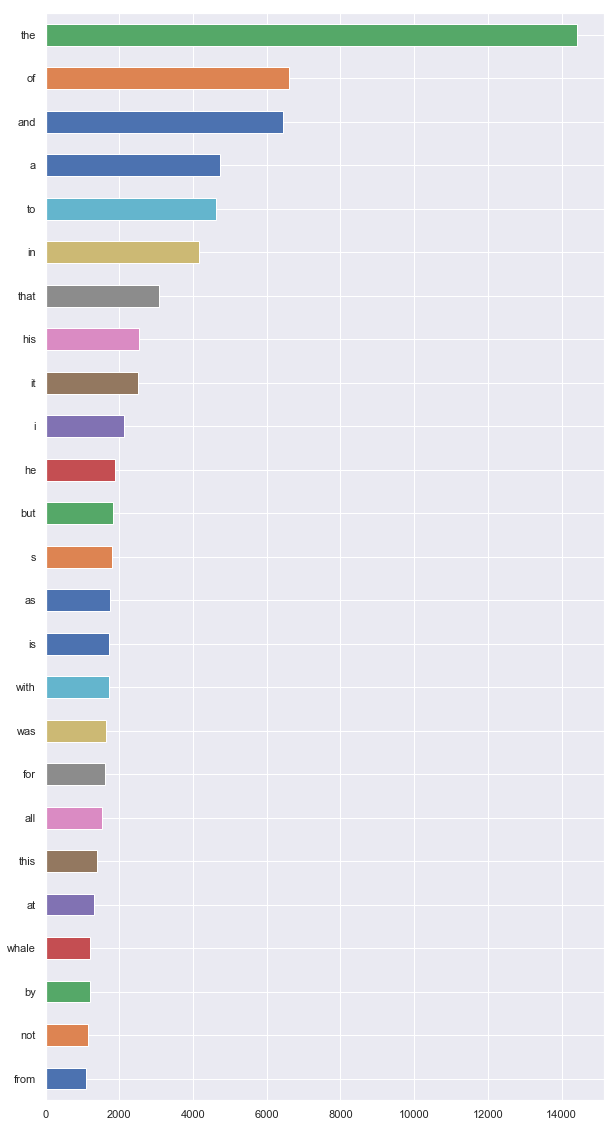

In [55]:
token_counts.head(25).sort_values().plot(kind='barh', figsize=(10,20))